In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'sakongmyoungheun'
os.environ['KAGGLE_KEY'] = 'eebb8c6baa890a589e08e51889cc3832'

In [3]:
!kaggle datasets download -d ademboukhris/cars-body-type-cropped

100% 1.34G/1.34G [00:12<00:00, 103MB/s]
100% 1.34G/1.34G [00:12<00:00, 119MB/s]


In [4]:
!unzip -q cars-body-type-cropped.zip

In [5]:
!mv Cars_Body_Type data

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models,transforms
from torch.utils.data import DataLoader

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [8]:
data_transforms = {
    'train': transforms.Compose([
        # 크기 재조정
        transforms.Resize((224, 224)),
        # 각도, 찌그러뜨림, 크기,
        transforms.RandomAffine(0, shear = 10, scale = (0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        # tensor로 전환
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [9]:
image_datasets = {
    'train': datasets.ImageFolder('data/train', data_transforms['train']),
    'validation': datasets.ImageFolder('data/valid', data_transforms['validation'])
}

In [10]:
dataloaders = {
    'train':DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation':DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=True
    )
}

In [11]:
print(len(image_datasets['train']),len(image_datasets['validation']))

5350 1397


In [12]:
!pip install tensorflow

In [13]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
import numpy as np

In [14]:
model = models.densenet121(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 87.4MB/s]


In [15]:
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [16]:
for param in model.parameters():
    param.requires_grad = True # 가져온 파라미터 (W,b)를 업데이트하지 않음

# 기존의 모델을 우리의 입맞에 맞게 바꾸는 과정
model.classifier = nn.Sequential(
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256,7),
).to(device)
print(model)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [17]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20

for epoch in range(epochs + 1):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        sum_losses = 0
        sum_accs = 0

        for x_batch, y_batch in dataloaders[phase]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses += loss.item()
            _, y_pred_index = torch.max(y_pred, 1)

            acc = (y_pred_index == y_batch).float().sum() / len(y_batch) * 100
            sum_accs += acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])
        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs} Loss: {avg_loss:.4f} Accuracy: {avg_acc:.2f}%')

train     : Epoch    1/20 Loss: 0.9182 Accuracy: 64.38%
validation: Epoch    1/20 Loss: 0.6884 Accuracy: 74.81%
train     : Epoch    2/20 Loss: 0.5414 Accuracy: 80.26%
validation: Epoch    2/20 Loss: 0.3783 Accuracy: 87.75%
train     : Epoch    3/20 Loss: 0.3884 Accuracy: 86.24%
validation: Epoch    3/20 Loss: 0.3897 Accuracy: 85.68%
train     : Epoch    4/20 Loss: 0.3322 Accuracy: 88.41%
validation: Epoch    4/20 Loss: 0.4255 Accuracy: 84.23%
train     : Epoch    5/20 Loss: 0.2819 Accuracy: 90.04%
validation: Epoch    5/20 Loss: 0.2528 Accuracy: 91.15%
train     : Epoch    6/20 Loss: 0.2843 Accuracy: 90.16%
validation: Epoch    6/20 Loss: 0.5603 Accuracy: 83.48%
train     : Epoch    7/20 Loss: 0.2301 Accuracy: 91.94%
validation: Epoch    7/20 Loss: 0.3930 Accuracy: 87.78%
train     : Epoch    8/20 Loss: 0.2165 Accuracy: 92.46%
validation: Epoch    8/20 Loss: 0.1927 Accuracy: 93.14%
train     : Epoch    9/20 Loss: 0.2093 Accuracy: 92.91%
validation: Epoch    9/20 Loss: 0.2466 Accuracy:

<function matplotlib.pyplot.show(close=None, block=None)>

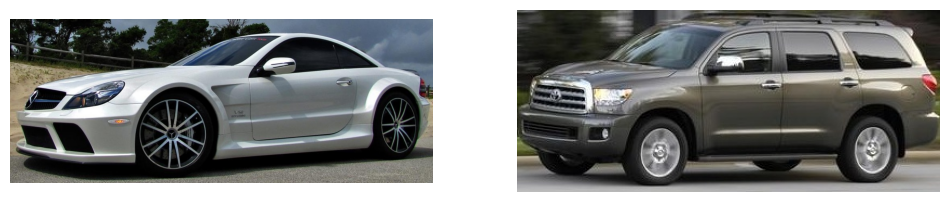

In [18]:
# 이미지를 test에서 골라서 분류가 잘 되는지 확인하기
from PIL import Image

img1 = Image.open('/content/data/valid/Coupe/01404_Mercedes-Benz-SL-Class-Coupe-2009_jpg.rf.5a2ba392cfbe17e88f89f29c16602d2f.jpg')
img2 = Image.open('/content/data/valid/SUV/00543_Toyota-Sequoia-SUV-2012_jpg.rf.218604ff3c584a8f8f67ca0de14cbfc6.jpg')

fig, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show

In [19]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)
print(img1_input.shape)
print(img2_input.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [20]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

torch.Size([2, 3, 224, 224])

In [21]:
y_pred = model(test_batch)
y_prob = nn.Softmax(1)(y_pred)

In [22]:
probs, idx = torch.topk(y_prob, k=3) # 분류 상위 3개 추출

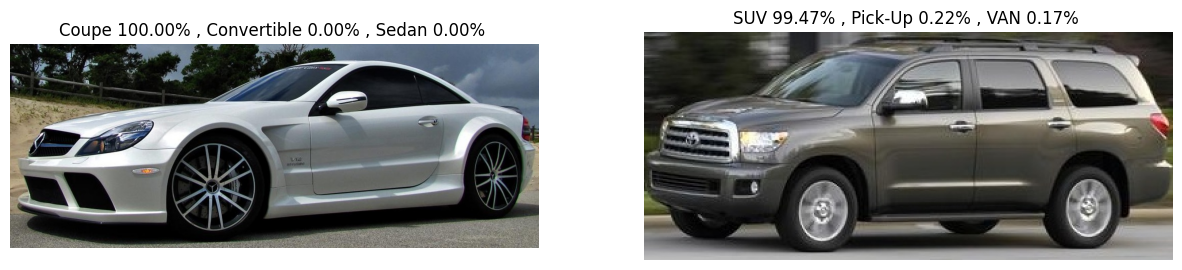

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].set_title('{} {:.2f}% , {} {:.2f}% , {} {:.2f}% '.format(
    image_datasets['validation'].classes[idx[0, 0]],
    probs[0, 0] * 100,
    image_datasets['validation'].classes[idx[0, 1]],
    probs[0, 1] * 100,
    image_datasets['validation'].classes[idx[0, 2]],
    probs[0, 2] * 100,
))
axes[0].imshow(img1)
axes[0].axis('off')

axes[1].set_title('{} {:.2f}% , {} {:.2f}% , {} {:.2f}% '.format(
    image_datasets['validation'].classes[idx[1, 0]],
    probs[1, 0] * 100,
    image_datasets['validation'].classes[idx[1, 1]],
    probs[1, 1] * 100,
    image_datasets['validation'].classes[idx[1, 2]],
    probs[1, 2] * 100,
))
axes[1].imshow(img2)
axes[1].axis('off')

plt.show()